In [1]:
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import spacy
import os
import requests
import random
import json
import nltk
import re

from NewsAPI import NewsApi 

# ignore all warinings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# helper function from NewsAPI:

# Create a dataframe by only using the fileds from variable 'columns'
def CreateDF(JsonArray,columns):
    dfData = pd.DataFrame()

    for item in JsonArray:
        itemStruct = {}

        for cunColumn in columns:
            itemStruct[cunColumn] = item[cunColumn]

        dfData = dfData.append(itemStruct,ignore_index=True)
    return dfData

In [4]:
baseUri = "https://newsapi.org/v2/"
# myKey = '9078433caf274bf3a1d002b191375d9c'
# myKey = 'cbfdf7f01cba4b538e3fe41721c8d600'
myKey = '6f1e5b5d4a3340a68d750d14a10f173a'
# myKey = 'fa42bba39a2a4643b312a12a127ae856'

## Set up conditions for scraping:
# The combination of the following two variable would form the period of scraping
startDateTime = dt.datetime(2022, 3, 1) # set start date time
endDateTime = dt.datetime(2022, 3, 3) # set end date time
# In this case, we are requesting posts between 2022/2/23 to 2022/2/25.

pageSize = 100
sources = None # To specify media source, but we are not focusing on any source. Setting to 'None' will return posts from all sources
symbol = 'bitcoin' # This is the keyword/topic that we are trying to search for.

# For each result's post, we are only going to look at these fields:
columns = ['author', 'publishedAt', 'title', 'description', 'content', 'source']

# Creating a pandas data frame to store all results
df = pd.DataFrame({'author': [], 'publishedAt': [], 'title': [], 'description': [], 'content': [], 'source': []})

# create a NewsApi object
newsapi = NewsApi(myKey)

# # For testing purpose:
# result = newsapi.GetEverything(symbol, startDateTime, endDateTime, 'en', sources, pageSize, 'publishedAt')
# print(result)
# print(len(result))

# main loop for scraping:
# using while loop recrated from teacher's code
# terminate condition is when 'endDate == startDate' is True
while startDateTime != endDateTime:
    # using method from cell above to scrape everything by giving conditions, store all result in to variable 'result'
    # However, the maximum post allowed to retrieve is 100.
    result = newsapi.GetEverything(symbol, startDateTime, endDateTime, 'en', sources, pageSize, 'publishedAt')
    print(result)
    numOfArticles = len(result['articles']) # to get the total number of posts
#     print("got " + str(numOfArticles) + " articles")
    print(startDateTime, endDateTime)
    if((endDateTime - startDateTime).days < 0):
        break
    
    # Since:
    # Usally there are more than 100 posts were published during the time period
    # And, the maximum post allowed to retrieve at a time is 100.
    # There is no way to get all the posts at a single time.
    # Thus:
    # We need some way to retrieve them by smaller fragments (100 at a time)
    # The NewAPI always return the most recent posts from endData (e.g. the most recent 100 posts before 2022/2/25)
    # We can keep updating the endData to retrieve multiple 100 fragments.
    
    # update the endData:
    # set endDate to the published date of the least recent post from this fragment
    endDateTime = dt.datetime.strptime(result['articles'][numOfArticles - 1]['publishedAt'], "%Y-%m-%dT%H:%M:%SZ") - dt.timedelta(seconds=1)
    
    # For all posts in 'result', dump them into a dataframe by using 'CreateDF' method from above
    rst = CreateDF(result['articles'], columns)
    # Finally, append this fragment dataframe into final output dataframe
    df = df.append(rst, ignore_index=True)

# OPTIONAL: save the output as CSV for later use
# df.to_csv('./bitcoin_lowest_everything.csv')

# print out the output
df

{'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2022-03-16, but you have requested 2022-03-01. You may need to upgrade to a paid plan.'}


KeyError: 'articles'

In [26]:
# {'status': 'error', 
#  'code': 'rateLimited',
#  'message': 'You have made too many requests recently. 
#  Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). 
#  Please upgrade to a paid plan if you need more requests.'}

# df = pd.read_csv('./bitcoin_lowest_everything.csv')
# df

# NLP using Spacy

In [27]:
# We need to tokenize and normalize the data first:
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# NLP pipeline
def pipeline_spacy(text):
    tokens = [] 
    if(type(text) != str): # check for NANs
        text = '' # if NAN, make it empty str
    doc = nlp(text)
    for t in doc: # for each word in the doc
        if not t.is_stop and not t.is_punct and not t.is_space: # remove stopwords, punctuations, white spaces
            n_token = WordNetLemmatizer().lemmatize(t.lemma_.lower()) # Lemmatization
            tokens.append(n_token)
        
    return tokens

In [28]:
df["td"] = df['title'] +' '+ df["description"]
td_list = df['td'].tolist()
doc_out_spacy = []

print(pipeline_spacy(td_list[1])) # demostration

for i in td_list:
    spacy_nlp = pipeline_spacy(i)
    doc_out_spacy.append(spacy_nlp)

# doc_out_spacy[0]

['bitcoin', 'true', 'stablecoin', 'stablecoins', 'seemingly', 'duplicate', 'problem', 'created', 'fiat', 'bitcoin', 'managed', 'solve']


# Analysis

In [29]:
def plot_wordcloud(comment_words):
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig("wordcloud.png",format='png',dpi=200)
    plt.show()
    
def wordcount(words, dct):
    counting = Counter(words)
    count = []
    for key, value in counting.items():
        if key in dct:
            count.append([key, value])
    return count

## Reading from Renault lexicon
# https://www.thomas-renault.com/data.php
renault_raw = pd.read_csv("./l1_lexicon.csv")
renault = renault_raw['keyword;sw'].str.split(';', expand=True)
renault = renault.rename(columns={0: 'word', 1: 'sw'})
renault['sw'] = renault['sw'].astype(float)

temp = renault.loc[renault['sw'] > 0]
positive = temp['word'].tolist()

temp = renault.loc[renault['sw'] < 0]
negative = temp['word'].tolist()

## Reading from Renault lexicon
# https://www.thomas-renault.com/data.php
renault_raw = pd.read_csv("./l2_lexicon.csv")
renault = renault_raw['keyword;sentiment'].str.split(';', expand=True)
renault = renault.rename(columns={0: 'word', 1: 'sentiment'})

temp = renault.loc[renault['sentiment'] == 'positive']
positive2 = temp['word'].tolist()

temp = renault.loc[renault['sentiment'] == 'negative']
negative2 = temp['word'].tolist()

## Spacy

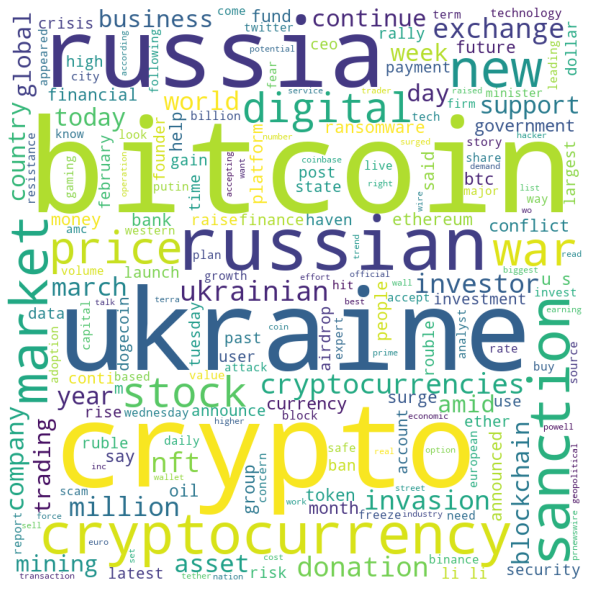

In [30]:
doc_out = nltk.flatten(doc_out_spacy)
random.shuffle(doc_out)

comment_words = ' '
for token in doc_out:
    comment_words = comment_words + token + ' '

# print(comment_words)

plot_wordcloud(comment_words)

In [31]:
tokens = doc_out
# Number of words in article
nwords = len(tokens)

nwc = wordcount(tokens, negative)   # wordcount(text,lexicon)
# [['die', 3], ['famine', 1], ['lies', 2], ['foe', 1], ['cruel', 1], ['gaudy', 1], ['waste', 2], ['pity', 1], ['besiege', 1], ['tattered', 1], ['weed', 1], ['sunken', 1], ['shame', 3], ['excuse', 1], ['cold', 1], ['beguile', 1], ['wrinkles', 1], ['dies', 1], ['abuse', 1], ['deceive', 1], ['hideous', 1], ['sap', 1], ['frost', 1], ['prisoner', 1], ['bereft', 1], ['ragged', 1], ['forbidden', 1], ['death', 1], ['burning', 1], ['weary', 1], ['feeble', 1], ['sadly', 1], ['annoy', 1], ['offend', 1], ['chide', 1], ['wilt', 2], ['fear', 1], ['wail', 1], ['weep', 1], ['deny', 1], ['hate', 2], ['conspire', 1]]

pwc = wordcount(tokens, positive)
# [['tender', 2], ['bright', 1], ['abundance', 1], ['sweet', 5], ['fresh', 2], ['spring', 1], ['proud', 1], ['worth', 1], ['beauty', 7], ['treasure', 3], ['praise', 2], ['fair', 3], ['proving', 1], ['warm', 1], ['fond', 1], ['lovely', 2], ['golden', 2], ['loveliness', 1], ['free', 1], ['beauteous', 2], ['great', 1], ['gentle', 2], ['work', 1], ['fairly', 1], ['excel', 1], ['leads', 1], ['willing', 1], ['happier', 2], ['gracious', 2], ['homage', 1], ['majesty', 1], ['heavenly', 1], ['strong', 1], ['adore', 1], ['like', 2], ['joy', 2], ['gladly', 1], ['pleasure', 1], ['sweetly', 1], ['happy', 1], ['pleasing', 1], ['well', 1], ['enjoys', 1], ['love', 4], ['beloved', 1]]

# Total number of positive/negative words
ntot, ptot = 0, 0
for i in range(len(nwc)):
    ntot += nwc[i][1]

for i in range(len(pwc)):
    ptot += pwc[i][1]


# Print results
print('Positive words:')
for i in range(len(pwc)):
    print(str(pwc[i][0]) + ': ' + str(pwc[i][1]))
print('Total number of positive words: ' + str(ptot))
print('\n')
print('Percentage of positive words: ' + str(round(ptot / nwords, 4)))
print('\n')
print('Negative words:')
for i in range(len(nwc)):
    print(str(nwc[i][0]) + ': ' + str(nwc[i][1]))
print('Total number of negative words: ' + str(ntot))
print('\n')
print('Percentage of negative words: ' + str(round(ntot / nwords, 4)))


Positive words:
powered: 3
transfer: 5
request: 13
announced: 48
industry: 21
portfolio: 8
partnership: 11
network: 12
benefit: 15
info: 1
healthcare: 3
infrastructure: 17
holding: 12
block: 25
q: 1
platform: 44
buy: 30
launch: 35
billionaire: 15
ev: 2
san: 8
long: 17
expanding: 5
data: 38
higher: 22
incredible: 2
solution: 15
bullish: 6
group: 54
link: 7
security: 43
raised: 19
official: 23
application: 6
analyst: 27
building: 7
yahoo: 7
quote: 1
mobile: 5
police: 2
paypal: 9
washington: 5
future: 45
international: 12
great: 13
stack: 3
promote: 1
deal: 9
payment: 42
rise: 36
equipment: 3
team: 17
news: 49
volume: 28
increased: 10
development: 14
computer: 4
tear: 2
engine: 1
mover: 12
institution: 11
smartphone: 6
enterprise: 2
surge: 45
efficient: 1
christmas: 1
interview: 4
vice: 17
k: 50
climb: 8
green: 11
strong: 11
approval: 10
grow: 5
provide: 8
ii: 6
build: 7
conference: 17
successful: 4
announcement: 5
valuable: 7
response: 5
sky: 1
medicine: 2
private: 5
leader: 8
location: 

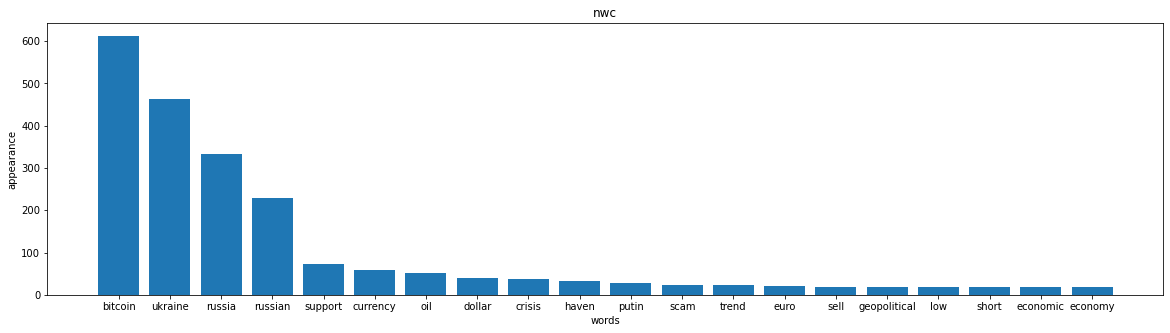

In [32]:
def Sort(list):
    temp = sorted(list, key = lambda x: x[1])
    temp.reverse()
    return temp

temp = Sort(nwc)

x = []
y = []

for i in temp[:20]:
    x.append(i[0])
    y.append(i[1])

plt.figure(figsize=(20, 5))
plt.title("nwc")
plt.xlabel('words')
plt.ylabel('appearance')
plt.bar(x, y)
plt.show()

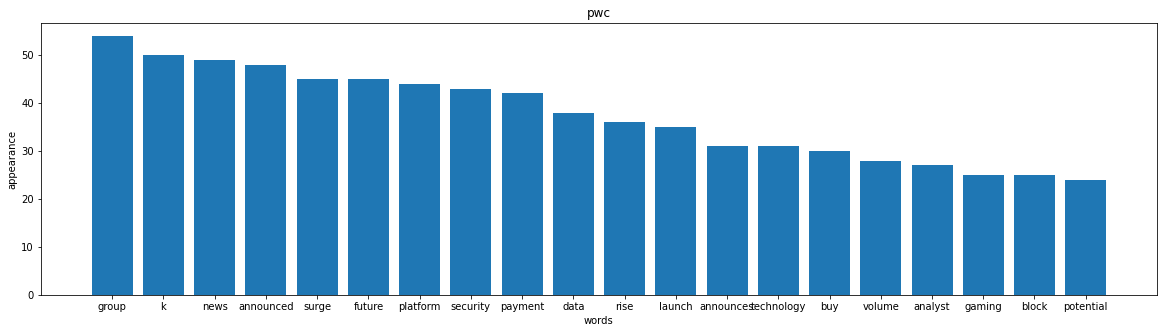

In [33]:
temp = Sort(pwc)

x = []
y = []

for i in temp[:20]:
    x.append(i[0])
    y.append(i[1])

plt.figure(figsize=(20, 5))
plt.title("pwc")
plt.xlabel('words')
plt.ylabel('appearance')
plt.bar(x, y)
plt.show()

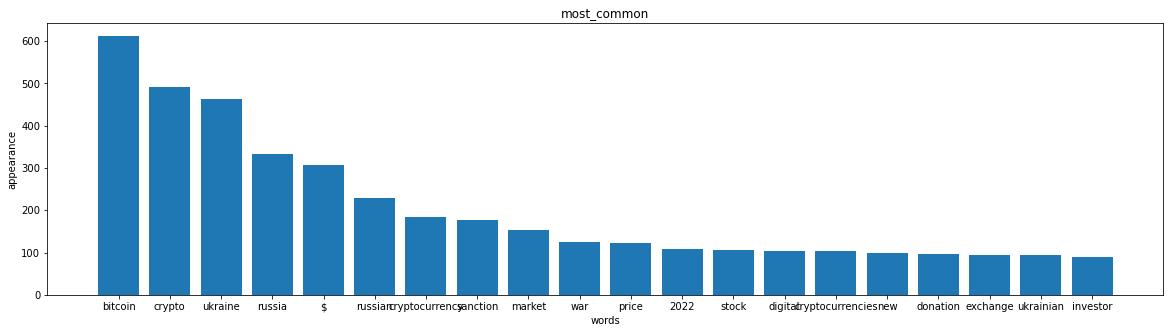

In [34]:
most_common = Counter(doc_out).most_common()

x = []
y = []

for i in most_common[:20]:
    x.append(i[0])
    y.append(i[1])
    
plt.figure(figsize=(20, 5))
plt.title("most_common")
plt.xlabel('words')
plt.ylabel('appearance')
plt.bar(x, y)
plt.show()

In [35]:
tokens = doc_out
# Number of words in article
nwords = len(tokens)

nwc = wordcount(tokens, negative2)   # wordcount(text,lexicon)
# [['die', 3], ['famine', 1], ['lies', 2], ['foe', 1], ['cruel', 1], ['gaudy', 1], ['waste', 2], ['pity', 1], ['besiege', 1], ['tattered', 1], ['weed', 1], ['sunken', 1], ['shame', 3], ['excuse', 1], ['cold', 1], ['beguile', 1], ['wrinkles', 1], ['dies', 1], ['abuse', 1], ['deceive', 1], ['hideous', 1], ['sap', 1], ['frost', 1], ['prisoner', 1], ['bereft', 1], ['ragged', 1], ['forbidden', 1], ['death', 1], ['burning', 1], ['weary', 1], ['feeble', 1], ['sadly', 1], ['annoy', 1], ['offend', 1], ['chide', 1], ['wilt', 2], ['fear', 1], ['wail', 1], ['weep', 1], ['deny', 1], ['hate', 2], ['conspire', 1]]

pwc = wordcount(tokens, positive2)
# [['tender', 2], ['bright', 1], ['abundance', 1], ['sweet', 5], ['fresh', 2], ['spring', 1], ['proud', 1], ['worth', 1], ['beauty', 7], ['treasure', 3], ['praise', 2], ['fair', 3], ['proving', 1], ['warm', 1], ['fond', 1], ['lovely', 2], ['golden', 2], ['loveliness', 1], ['free', 1], ['beauteous', 2], ['great', 1], ['gentle', 2], ['work', 1], ['fairly', 1], ['excel', 1], ['leads', 1], ['willing', 1], ['happier', 2], ['gracious', 2], ['homage', 1], ['majesty', 1], ['heavenly', 1], ['strong', 1], ['adore', 1], ['like', 2], ['joy', 2], ['gladly', 1], ['pleasure', 1], ['sweetly', 1], ['happy', 1], ['pleasing', 1], ['well', 1], ['enjoys', 1], ['love', 4], ['beloved', 1]]

# Total number of positive/negative words
ntot, ptot = 0, 0
for i in range(len(nwc)):
    ntot += nwc[i][1]

for i in range(len(pwc)):
    ptot += pwc[i][1]


# Print results
print('Positive words:')
for i in range(len(pwc)):
    print(str(pwc[i][0]) + ': ' + str(pwc[i][1]))
print('Total number of positive words: ' + str(ptot))
print('\n')
print('Percentage of positive words: ' + str(round(ptot / nwords, 4)))
print('\n')
print('Negative words:')
for i in range(len(nwc)):
    print(str(nwc[i][0]) + ': ' + str(nwc[i][1]))
print('Total number of negative words: ' + str(ntot))
print('\n')
print('Percentage of negative words: ' + str(round(ntot / nwords, 4)))


Positive words:
partnership: 11
benefit: 15
hold: 15
holding: 12
buy: 30
launch: 35
long: 17
expanding: 5
higher: 22
incredible: 2
rewarding: 8
bullish: 6
best: 22
great: 13
repurchase: 5
deal: 9
rise: 36
climbed: 1
increased: 10
development: 14
surge: 45
efficient: 1
climb: 8
green: 11
strong: 11
approval: 10
leap: 1
grow: 5
successful: 4
won: 5
dealing: 4
add: 11
increase: 16
uptrend: 2
bought: 8
jump: 15
merging: 2
thanks: 6
acquiring: 2
optimistic: 2
dip: 5
acquire: 3
lift: 2
squeeze: 5
acquisition: 3
reward: 5
launching: 3
discount: 5
adding: 5
boom: 7
cool: 2
impressive: 1
boost: 11
interesting: 3
surged: 23
breakout: 4
purchase: 7
added: 11
love: 2
gainer: 3
exceeded: 3
held: 5
power: 15
buying: 9
flying: 1
expansion: 5
surging: 7
comeback: 3
upward: 4
acquires: 3
consolidation: 2
increasing: 4
good: 11
outperforming: 1
upside: 3
expands: 7
excellent: 2
rich: 1
growing: 11
success: 3
partnering: 1
skyrocketing: 3
jumped: 7
grows: 1
breakthrough: 2
celebration: 1
approved: 3
jump

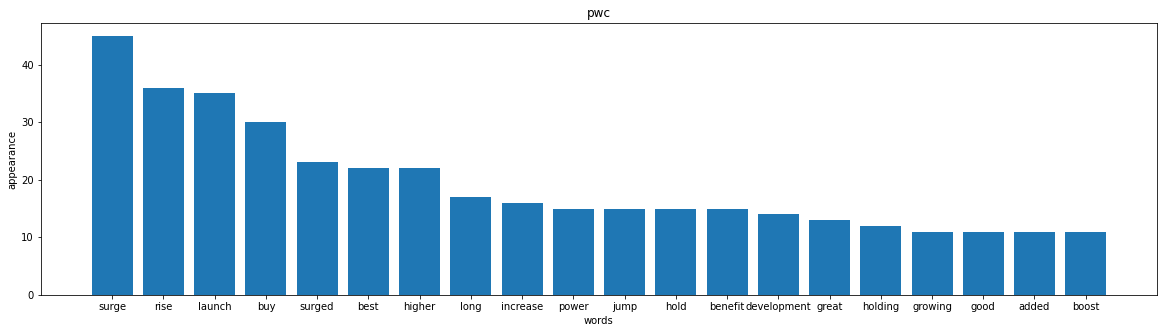

In [36]:
temp = Sort(pwc)

x = []
y = []

for i in temp[:20]:
    x.append(i[0])
    y.append(i[1])

plt.figure(figsize=(20, 5))
plt.title("pwc")
plt.xlabel('words')
plt.ylabel('appearance')
plt.bar(x, y)
plt.show()

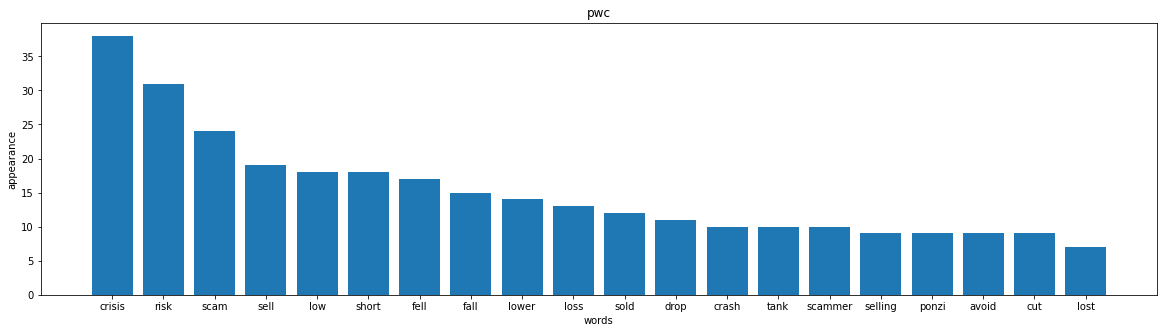

In [37]:
temp = Sort(nwc)

x = []
y = []

for i in temp[:20]:
    x.append(i[0])
    y.append(i[1])

plt.figure(figsize=(20, 5))
plt.title("pwc")
plt.xlabel('words')
plt.ylabel('appearance')
plt.bar(x, y)
plt.show()